<figure>
<!-- <center><img src ="https://drive.google.com/uc?export=view&id=1hSOAfRhJ_jo-MZAjq81VYJu5bZNL7EjD" width = "800" height = '500'/> -->

*About the problem*
> The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa.

*Objective of this challenge*
> The objective of this challenge is to create machine learning or a deep learning model using open-source CO2 emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.

These solutions will enable EY, governments, and other actors to estimate carbon emission levels across Africa, even in places where on-the-ground monitoring is not possible.



## Table of contents:

1. [Installing and importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Outliers](#Outliers)
5. [Geo Visualisation - EDA](#Geo)
5. [Missing values and duplicates](#Missing)
6. [Date features EDA](#Dates)
7. [Correlations - EDA](#Correlations)
9. [Timeseries visualization - EDA](#Timeseries)
10. [Feature engineering](#Engineering)
11. [Modelling](#Modelling)
12. [Making predictions of the test set and creating a submission file](#Predictions)

<a name="Libraries"></a>
## 1. Installing and importing libraries


In [39]:
#%%capture
# Install relevant libraries
#!pip install geopandas folium 

In [43]:
# Import libraries
import pandas as pd
import numpy as np
import random

from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, Normalizer, QuantileTransformer
import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor, RandomTreesEmbedding
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [44]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

<a name="Data"></a>
## 2. Loading and previewing data

In [45]:
# Load files
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
samplesubmission = pd.read_csv('SampleSubmission.csv')

# Preview train dataset
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-23.73_28.77_2019_1,-23.73000,28.77000,2019,1,0.00017,0.71317,0.00010,0.22393,24.93944,...,5566.22202,54826.03262,4606.20999,19.11528,0.35378,24.95195,49.05395,-89.63803,17.98887,86.05170
1,ID_-23.73_28.77_2019_2,-23.73000,28.77000,2019,2,-0.00016,0.81291,-0.00014,0.08028,16.62416,...,3711.51137,68491.75334,3034.46166,12.21866,0.24499,4.70886,42.58668,-89.90431,22.77325,88.87567
2,ID_-23.73_28.77_2019_3,-23.73000,28.77000,2019,3,-0.00007,0.86031,-0.00006,0.16105,-13.23724,...,2136.38519,78967.73955,1433.48259,6.06274,0.24510,76.06063,34.73754,-83.59525,17.43730,91.72311
3,ID_-23.73_28.77_2019_4,-23.73000,28.77000,2019,4,0.00015,0.42228,0.00009,0.04650,-13.53465,...,3841.85302,64592.80677,2878.51292,6.38823,0.21090,75.91237,60.29449,-71.89673,11.97782,92.88387
4,ID_-23.73_28.77_2019_5,-23.73000,28.77000,2019,5,0.00002,1.00458,0.00003,0.21425,-13.47572,...,1295.68817,86804.02539,1094.66534,9.20625,0.26110,-13.34608,50.19449,-77.46208,24.37427,94.87833


In [46]:
colr=train.columns.to_list()

for i in colr:
    if train[i].dtypes in ["object", "category"]:
        print(i)

ID_LAT_LON_YEAR_WEEK


In [47]:
# Preview test dataset
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-23.53_27.47_2019_1,-23.53000,27.47000,2019,1,0.00008,0.45447,0.00003,0.11429,-80.28631,...,74897.05200,2180.26654,81287.07448,1562.03102,10.73412,0.28066,-31.23017,33.33797,-93.21726,23.35825
1,ID_-23.53_27.47_2019_2,-23.53000,27.47000,2019,2,0.00018,0.42317,0.00006,0.07510,-17.76569,...,84222.65352,982.61906,90307.65001,927.11122,5.25002,0.23893,66.49090,58.13779,-85.00147,13.41648
2,ID_-23.53_27.47_2019_3,-23.53000,27.47000,2019,3,0.00006,0.71309,0.00004,0.11421,16.72565,...,78922.49079,1582.96493,85383.15185,1006.77811,6.81937,0.25868,75.92319,41.33695,-83.26754,16.27300
3,ID_-23.53_27.47_2019_4,-23.53000,27.47000,2019,4,0.00048,0.43445,0.00017,0.13139,-22.47534,...,61135.91959,3935.41998,67490.03136,3428.42353,6.23363,0.28154,-11.02323,60.68987,-77.76372,22.79396
4,ID_-23.53_27.47_2019_5,-23.53000,27.47000,2019,5,0.00019,0.78304,0.00014,0.16114,4.75036,...,78494.24739,1647.53853,84478.74304,1122.53409,11.81025,0.28156,-13.29451,51.00713,-76.62065,23.19824


In [48]:
# Preview sample submission file
samplesubmission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,0
1,ID_-23.53_27.47_2019_2,0
2,ID_-23.53_27.47_2019_3,0
3,ID_-23.53_27.47_2019_4,0
4,ID_-23.53_27.47_2019_5,0


In [49]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((74005, 76), (28085, 75), (28085, 2))

In [50]:
# Train to test sets ratio
(test.shape[0]) / (train.shape[0] + test.shape[0])

0.2751004016064257

<a name="Statistics"></a>
## 3. Statistical summaries

In [51]:
# Train statistical summary
train.describe(include = 'all').T.style.highlight_max(color="orange")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID_LAT_LON_YEAR_WEEK,74005,74005,ID_-27.23_24.87_2022_22,1,nan,nan,nan,nan,nan,nan,nan
latitude,74005.000000,nan,nan,nan,-27.829723,2.760589,-33.930000,-29.630000,-28.130000,-25.730000,-23.730000
longitude,74005.000000,nan,nan,nan,27.782742,2.746672,21.070000,26.670000,28.770000,29.470000,31.170000
year,74005.000000,nan,nan,nan,2020.478049,1.111261,2019.000000,2019.000000,2020.000000,2021.000000,2022.000000
week_no,74005.000000,nan,nan,nan,26.156098,14.843840,1.000000,13.000000,26.000000,39.000000,52.000000
SulphurDioxide_SO2_column_number_density,72075.000000,nan,nan,nan,0.000263,0.000599,-0.000989,-0.000066,0.000147,0.000441,0.009526
SulphurDioxide_SO2_column_number_density_amf,72075.000000,nan,nan,nan,0.515875,0.196766,0.133738,0.371745,0.488695,0.623530,1.673412
SulphurDioxide_SO2_slant_column_number_density,72075.000000,nan,nan,nan,0.000091,0.000199,-0.000828,-0.000034,0.000073,0.000191,0.001871
SulphurDioxide_cloud_fraction,72075.000000,nan,nan,nan,0.105690,0.069555,0.000000,0.052482,0.099513,0.152480,0.299987
SulphurDioxide_sensor_azimuth_angle,72075.000000,nan,nan,nan,4.487627,52.246537,-110.027657,-18.178128,-10.987544,59.119988,83.743980


From the above statistical summary, we can deduce some of the following insights:
 - The train data provided ranges from year *2019 to 2022*
 - Minimum recorded CO2 emissions is *0.04806* and a maximum of *1181701.2*
 - Week of the year starts from 1 to 52
 - The latitude and longitudes ranges show that the regions are mostly within South Africa 

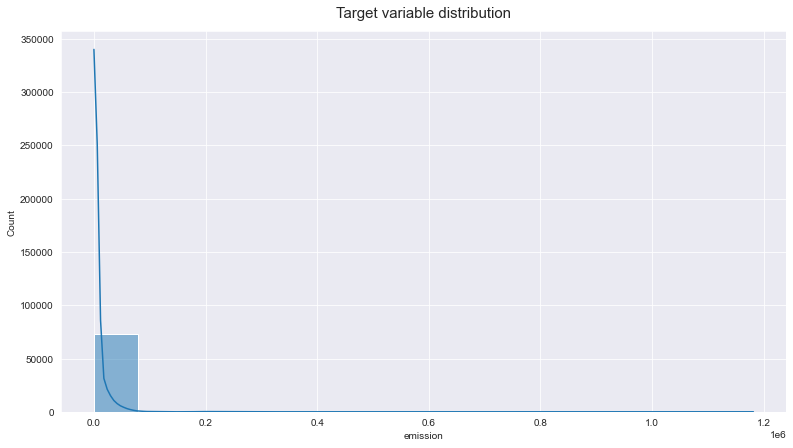

None

17.038027449698163

In [52]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.emission, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.emission.skew())

In [53]:
train = train.copy()

In [54]:
#train_copy["emission"] = np.log(train_copy.emission) 

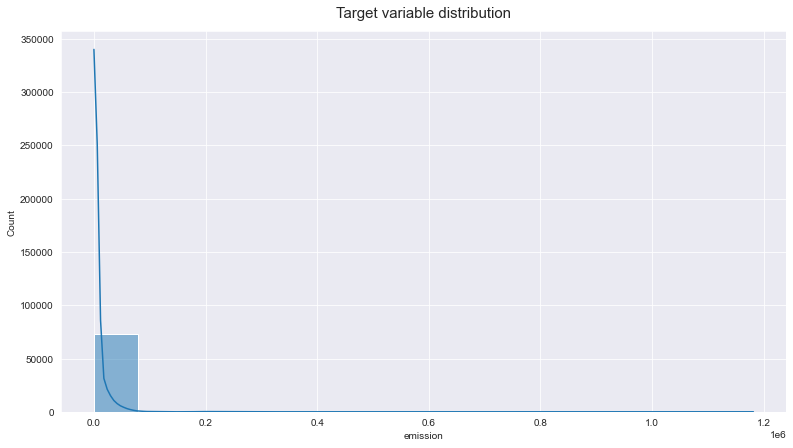

None

17.038027449698163

In [55]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.emission, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.emission.skew())

#### The target variable is skewed to the right with a  degree of ~-0.4685.

Some of the techniques used to handle skewness include:
- Log transform
- Box-cox transform
- Square root transform
- *etc*

<a name="Outliers"></a>
## 4. Outliers


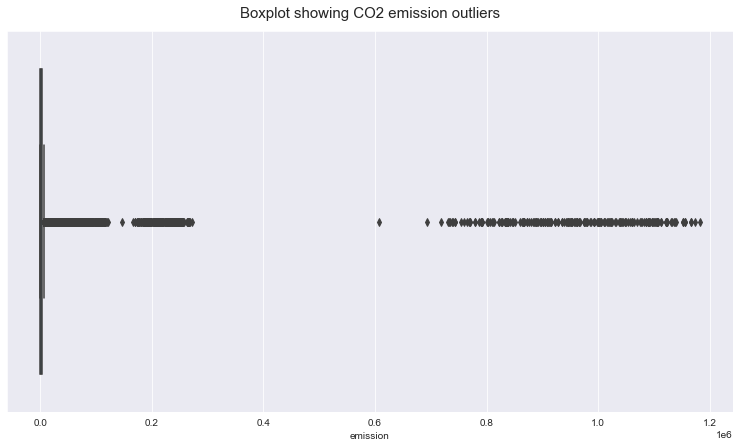

In [56]:
# Plotting boxplot for the CO2 emissions
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.emission)
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)  
plt.show()

Outliers are those data points which differ significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...
 

<a name="Geo"></a>
## 5. Geo Visualisation - EDA

In [57]:
# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude'])
test_coords = test.drop_duplicates(subset = ['latitude', 'longitude'])
train_coords['set_type'], test_coords['set_type'] = 'train', 'test'

all_data = pd.concat([train_coords, test_coords], ignore_index = True)
# Create point geometries

geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(
    all_data[["latitude", "longitude", "set_type"]], geometry=geometry
)

# Preview the geopandas df
geo_df.head()

,latitude,longitude,set_type,geometry
0,-23.73000,28.77000,train,POINT (28.77000 -23.73000)
1,-23.73000,28.77000,train,POINT (28.77000 -23.73000)
2,-23.73000,28.87000,train,POINT (28.87000 -23.73000)
3,-23.73000,28.87000,train,POINT (28.87000 -23.73000)
4,-23.73000,28.97000,train,POINT (28.97000 -23.73000)


In [58]:
# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # assign a color marker for the type set
    if geo_df.set_type[i] == "train":
        type_color = "green"
    elif geo_df.set_type[i] == "test":
        type_color = "orange"

    # Place the markers 
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            popup= 
            "Set: " + str(geo_df.set_type[i]) + "<br>"
            "Coordinates: " + str([round(x, 2) for x in geo_df_list[i]]),
            color =  type_color),
        )
    i = i + 1
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

<a name="Missing"></a>
## 6. Missing values and duplicates

In [59]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(True, True)

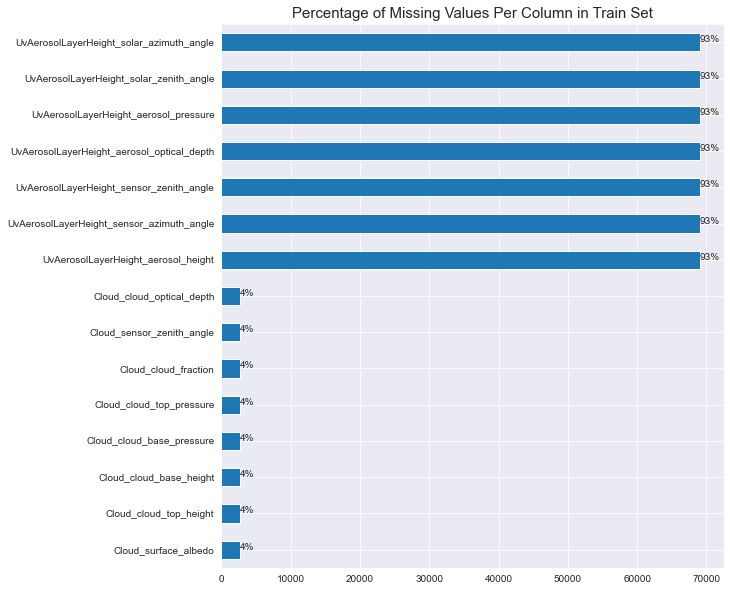

In [60]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

<a name="Dates"></a>
## 7. Date features EDA

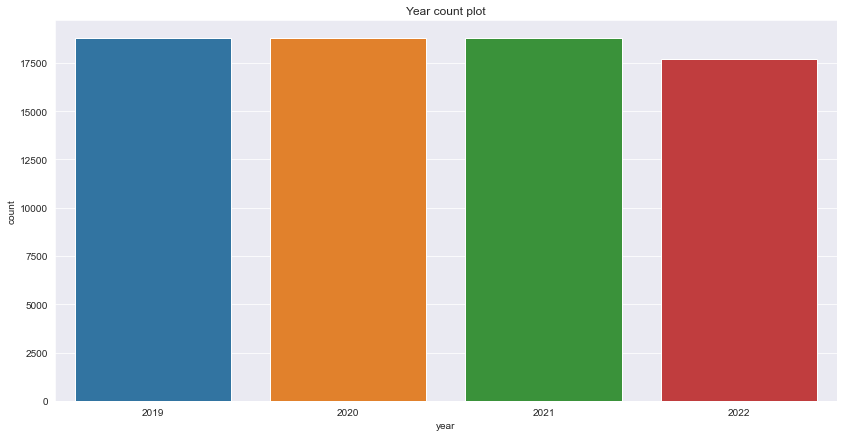

In [61]:
# Year countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'year', data = train)
plt.title('Year count plot')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the years
- Year 2022 has fewer number of observations

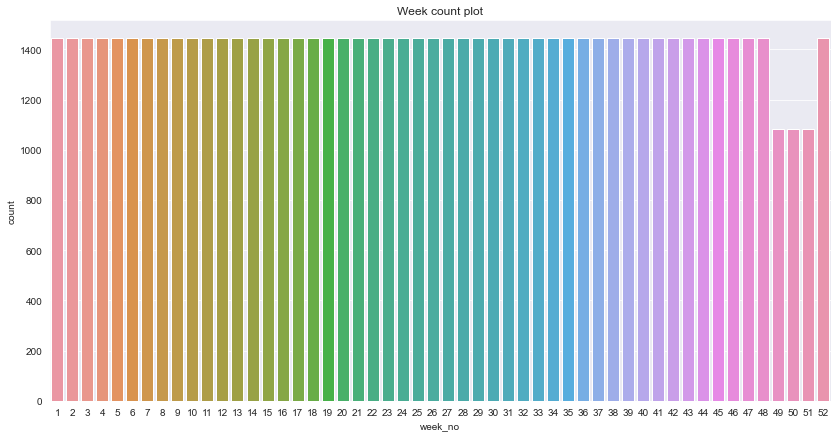

In [62]:
# Week countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'week_no', data = train)
plt.title('Week count plot')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the weeks
- Weeks 49, 50 and 51  have fewer number of observations when compared to the other weeks

<a name="Correlations"></a>
## 8. Correlations - EDA

In [63]:
# Top 20 correlated features to the target
top20_corrs = abs(train.corr()['emission']).sort_values(ascending = False).head(20)
top20_corrs

emission                                                 1.00000
NitrogenDioxide_NO2_column_number_density                0.28840
NitrogenDioxide_tropospheric_NO2_column_number_density   0.28416
NitrogenDioxide_NO2_slant_column_number_density          0.24445
SulphurDioxide_SO2_column_number_density_15km            0.07252
SulphurDioxide_SO2_slant_column_number_density           0.06635
SulphurDioxide_SO2_column_number_density                 0.06020
Cloud_surface_albedo                                     0.05896
UvAerosolLayerHeight_sensor_azimuth_angle                0.05497
longitude                                                0.05394
UvAerosolIndex_sensor_altitude                           0.04477
UvAerosolLayerHeight_solar_azimuth_angle                 0.04376
latitude                                                 0.04372
NitrogenDioxide_sensor_altitude                          0.04069
UvAerosolLayerHeight_aerosol_optical_depth               0.04021
CarbonMonoxide_sensor_alt

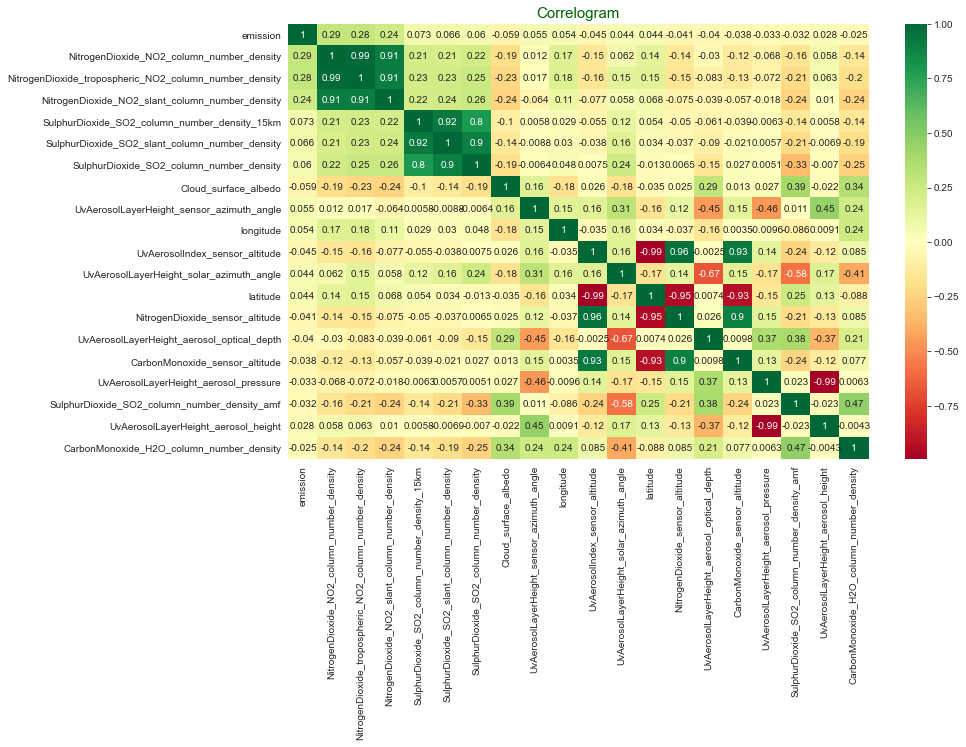

In [64]:
# Quantify correlations between features
corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

<a name="Timeseries"></a>
## 9. Timeseries visualization - EDA

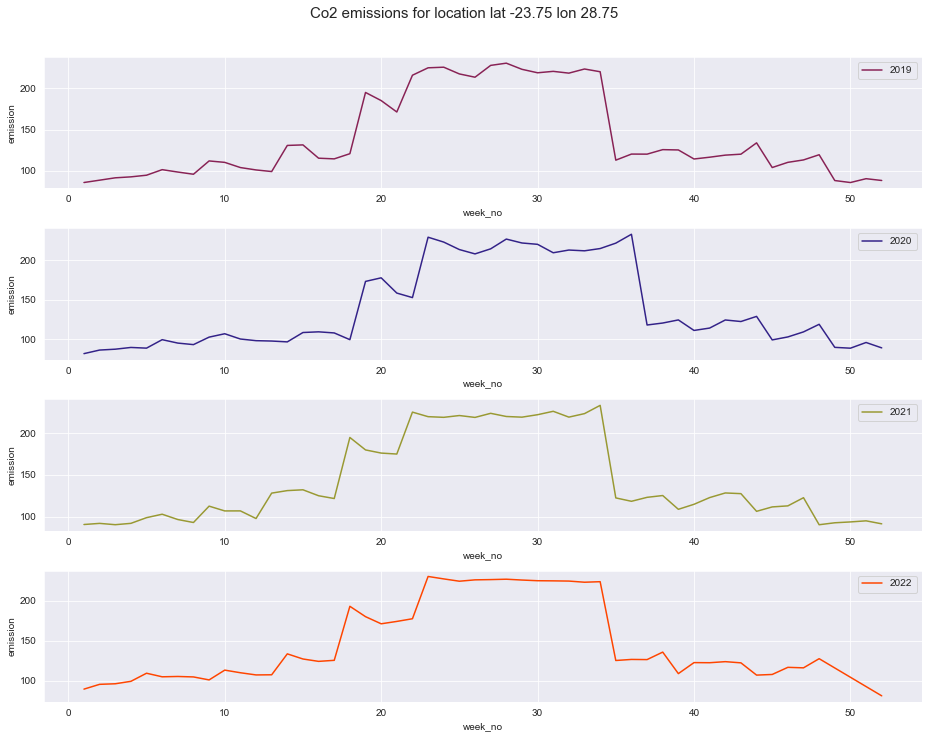

In [65]:
# Sample a unique location and visualize its emissions across the years
train.latitude, train.longitude = round(train.latitude, 2), round(train.longitude, 2)
sample_loc = train[(train.latitude == -23.73) & (train.longitude == 28.77)]

# Plot a line plot
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (13, 10))
fig.suptitle('Co2 emissions for location lat -23.75 lon 28.75', y=1.02, fontsize = 15)

for ax, data, year, color, in zip(axes.flatten(), sample_loc, sample_loc.year.unique(), ['#882255','#332288', '#999933' , 'orangered']):
  df = sample_loc[sample_loc.year == year]
  sns.lineplot(df.week_no, df.emission, ax = ax, label = year, color = color)
plt.legend()
plt.tight_layout()

<a name="Engineering"></a>
## 10. Feature engineering









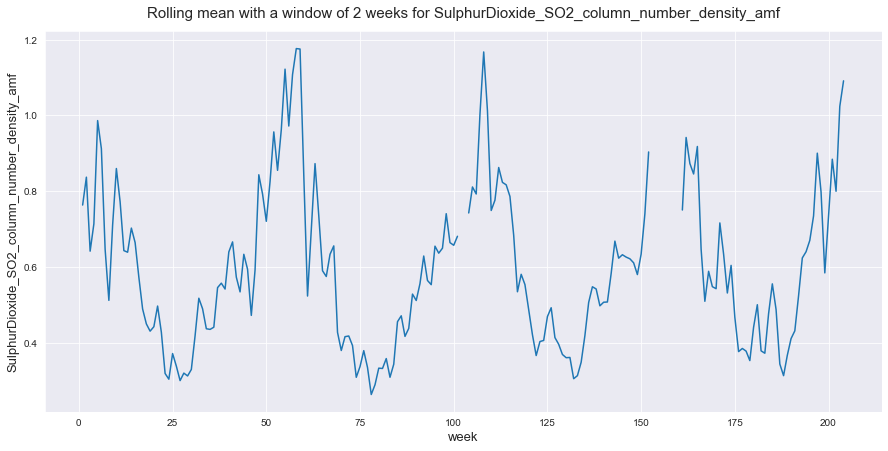

In [66]:
# Examples of feature engineering - Aggregations, cumulative differences, moving averages ...
# Lets explore the rolling mean
# First we create a unique location from lat lon
train['location'] = [str(x) + '_' + str(y) for x, y in zip(train.latitude, train.longitude)]

# Filter based on one location
example_loc = train[train.location == '-23.73_28.77']

# Calculate rolling mean for SulphurDioxide_SO2_column_number_density_amf with a window of 2 weeks
rolling_mean = example_loc['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 2).mean()

# Visualise rolling mean
plt.figure(figsize = (15, 7))
rolling_mean.plot()
plt.title('Rolling mean with a window of 2 weeks for SulphurDioxide_SO2_column_number_density_amf', y = 1.02, fontsize = 15)
plt.xlabel('week', y = 1.05, fontsize = 13)
plt.ylabel('SulphurDioxide_SO2_column_number_density_amf', x = 1.05, fontsize = 13)
plt.show()

In [67]:
# Generate the above feature - rolling mean for all locations for both the train and test

# Feature engineering train
train_roll_mean = train.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[train.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
train_roll_mean.drop(['level_1', 'emission', 'location'], axis = 1, inplace = True)
train_roll_mean.columns = [col + '_roll_mean' for col in train_roll_mean.columns]

# Feature engineering test
test.latitude, test.longitude = round(test.latitude, 2), round(test.longitude, 2)
test['location'] = [str(x) + '_' + str(y) for x, y in zip(test.latitude, test.longitude)]
test_roll_mean = test.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[test.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
test_roll_mean.drop(['level_1', 'location'], axis = 1, inplace = True)
test_roll_mean.columns =  [col + '_roll_mean' for col in test_roll_mean.columns]
test_roll_mean.head()

,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00013,0.43882,0.00005,0.09470,-49.02600,55.93510,-92.36411,26.77170,0.00002,0.02549,...,79559.85276,1581.44280,85797.36225,1244.57112,7.99207,0.25980,17.63036,45.73788,-89.10936,18.38737
2,0.00012,0.56813,0.00005,0.09466,-0.52002,44.99212,-88.07020,21.95860,0.00002,0.02503,...,81572.57215,1282.79200,87845.40093,966.94467,6.03470,0.24881,71.20704,49.73737,-84.13451,14.84474
3,0.00027,0.57377,0.00011,0.12280,-2.87484,47.10618,-82.84357,22.25336,0.00004,0.02369,...,70029.20519,2759.19246,76436.59161,2217.60082,6.52650,0.27011,32.44998,51.01341,-80.51563,19.53348
4,0.00034,0.60875,0.00016,0.14627,-8.86249,49.32330,-77.79334,22.96216,0.00007,0.02297,...,69815.08349,2791.47925,75984.38720,2275.47881,9.02194,0.28155,-12.15887,55.84850,-77.19218,22.99610


In [68]:
# Merge engineered features with train and test set

#Train
train_eng = train.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(train_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Test
test_eng = test.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(test_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Preview engineered test set
test_eng.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,ID_-23.53_27.47_2019_1,-23.53000,27.47000,2019,1,0.00008,0.45447,0.00003,0.11429,-80.28631,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_-23.53_27.47_2019_2,-23.53000,27.47000,2019,2,0.00018,0.42317,0.00006,0.07510,-17.76569,...,79559.85276,1581.44280,85797.36225,1244.57112,7.99207,0.25980,17.63036,45.73788,-89.10936,18.38737
2,ID_-23.53_27.47_2019_3,-23.53000,27.47000,2019,3,0.00006,0.71309,0.00004,0.11421,16.72565,...,81572.57215,1282.79200,87845.40093,966.94467,6.03470,0.24881,71.20704,49.73737,-84.13451,14.84474
3,ID_-23.53_27.47_2019_4,-23.53000,27.47000,2019,4,0.00048,0.43445,0.00017,0.13139,-22.47534,...,70029.20519,2759.19246,76436.59161,2217.60082,6.52650,0.27011,32.44998,51.01341,-80.51563,19.53348
4,ID_-23.53_27.47_2019_5,-23.53000,27.47000,2019,5,0.00019,0.78304,0.00014,0.16114,4.75036,...,69815.08349,2791.47925,75984.38720,2275.47881,9.02194,0.28155,-12.15887,55.84850,-77.19218,22.99610


In [69]:
#Combine the train and test data for consistent preprocessing
new_data = pd.concat([train_eng, test_eng])

In [70]:
new_data.drop(columns=["year","week_no"], inplace=True)

In [71]:
cols=new_data.columns.to_list()

for col in cols:
    if new_data[col].isnull().mean()*100>=90:
        print(f"The percentage of null columns in the {col} column is {round(new_data[col].isnull().mean()*100, 2)}%")
        new_data.drop(columns=[col], inplace=True)

The percentage of null columns in the UvAerosolLayerHeight_aerosol_height column is 93.33%
The percentage of null columns in the UvAerosolLayerHeight_aerosol_pressure column is 93.33%
The percentage of null columns in the UvAerosolLayerHeight_aerosol_optical_depth column is 93.33%
The percentage of null columns in the UvAerosolLayerHeight_sensor_zenith_angle column is 93.33%
The percentage of null columns in the UvAerosolLayerHeight_sensor_azimuth_angle column is 93.33%
The percentage of null columns in the UvAerosolLayerHeight_solar_azimuth_angle column is 93.33%
The percentage of null columns in the UvAerosolLayerHeight_solar_zenith_angle column is 93.33%
The percentage of null columns in the UvAerosolLayerHeight_aerosol_height_roll_mean column is 95.81%
The percentage of null columns in the UvAerosolLayerHeight_aerosol_pressure_roll_mean column is 95.81%
The percentage of null columns in the UvAerosolLayerHeight_aerosol_optical_depth_roll_mean column is 95.81%
The percentage of null

In [72]:
_cols=new_data.columns.to_list()
_name,_col=[],[]

for col in _cols:
    if new_data[col].isnull().any()==True:
        _name.append(col), _col.append(round(new_data[col].isnull().mean()*100, 2))
        
pd.DataFrame({"Column names":_name, "Percentage of null values":_col}).sort_values(by="Percentage of null values", ascending=False).reset_index(drop=True).head()

,Column names,Percentage of null values
0,emission,27.51000
1,Cloud_cloud_fraction_roll_mean,7.12000
2,Cloud_solar_azimuth_angle_roll_mean,7.12000
3,Cloud_sensor_zenith_angle_roll_mean,7.12000
4,Cloud_sensor_azimuth_angle_roll_mean,7.12000


In [73]:
#Fill in the missing values
new_data.fillna(0, inplace=True)

In [74]:
train_data=new_data[:len(train_eng)]
test_data=new_data[len(train_eng):]

In [75]:
train_data.shape, test_data.shape

((74005, 131), (28085, 131))

In [76]:
np.zeros(len(train_data)).shape
NBR_FOLD=3

In [77]:
def preprocess(train_data, test_data, one_hot=True, extra_ftrs=False):
    for c in train_data.dtypes[train_data.dtypes=="object"].index:
        if c in ["emission", "ID_LAT_LON_YEAR_WEEK"]:
            continue;
        train_data[c]=train_data[c].astype("category")
        test_data[c]=test_data[c].astype("category")
    
    features = [i for i in new_data.columns if i not in ["emission", "ID_LAT_LON_YEAR_WEEK"]]
    features = [i for i in features if "Latitude" not in i and "Longitude" not in i]
    
    target = "emission"
    
    num_cols = [i for i in features if train_data[i].dtype not in ["object","category"]]
    cat_cols = [i for i in features if train_data[i].dtype in ["object","category"]]
    
    if extra_ftrs:
        NBR_FTRS=20
        
        NBR_KM = NBR_FTRS
        for ncl in range(2, NBR_KM):
            cls = KMeans(n_clusters=ncl, random_state=0)
            cls.fit(pd.concat([train_data[num_cols], test_data[num_cols]]))
            train_data["KMeans_cluster" + str(ncl)] = cls.predict(train_data[num_cols])
            test_data["KMeans_cluster" + str(ncl)] = cls.predict(test_data[num_cols])
            
        NBR_PCA = NBR_FTRS
        pca= PCA(n_components=NBR_PCA, random_state=0)
        pca.fit(pd.concat([train_data[num_cols], test_data[num_cols]]))
        train_data[["PCA_cluster" + str(ncl) for ncl in range(NBR_PCA)]] = pca.transform(train_data[num_cols])
        test_data[["PCA_cluster" + str(ncl) for ncl in range(NBR_PCA)]] = pca.transform(test_data[num_cols])
        
        random_tree = RandomTreesEmbedding(n_estimators=NBR_FTRS, max_depth=1, random_state=0)
        random_tree.fit(pd.concat([train_data[num_cols], test_data[num_cols]]))
        train_trans = random_tree.transform(train_data[num_cols]).toarray()
        NBR_TREE = train_trans.shape[1]
        train_data[["random_tree_cluster" + str(ncl) for ncl in range(NBR_TREE)]] = train_trans
        test_data[["random_tree_cluster" + str(ncl) for ncl in range(NBR_TREE)]] = random_tree.transform(test_data[num_cols]).toarray()
        
        num_cols += ["KMeans_cluster" + str(ncl) for ncl in range(2, NBR_KM)] + ["PCA_cluster" + str(ncl) for ncl in range(NBR_PCA)] + ["random_tree_cluster" + str(ncl) for ncl in range(NBR_TREE)]
    
    features= cat_cols + num_cols

    if one_hot:
        enc= OneHotEncoder()
        enc_cat = enc.fit_transform(pd.concat([train_data[cat_cols], test_data[cat_cols]])).toarray()

        train_data[[f"enc_cat{i}" for i in range(enc_cat.shape[1])]] = enc_cat[:len(train_data)]
        test_data[[f"enc_cat{i}" for i in range(enc_cat.shape[1])]] = enc_cat[len(train_data):]

        features = num_cols + [f"enc_cat{i}" for i in range(enc_cat.shape[1])]
        num_cols = features
    
    scaler = Normalizer()
    scaler.fit(pd.concat([train_data[num_cols], test_data[num_cols]]))
    train_data[num_cols] = scaler.transform(train_data[num_cols])
    test_data[num_cols] = scaler.transform(test_data[num_cols])   


    return train_data, test_data, features, target
                                    

In [78]:
def train_model(train_data, test_data, features, target):
    
    skfold=StratifiedKFold(n_splits=NBR_FOLD)
    for fold, (train_indices, fold_indices) in enumerate(skfold.split(X=train_data[features], y= "ID_" + train_data["latitude"].astype(str) + train_data["longitude"].astype(str))):
        train_data.loc[fold_indices, "kfold"] = fold
        
    tdt=np.zeros(len(train_data))
    pred=np.zeros(len(test_data))
    
    for fold in range(NBR_FOLD):
        train_set = train_data[train_data["kfold"] != fold].reset_index(drop=True)
        val_set = train_data[train_data["kfold"] == fold].reset_index(drop=True)
        cat_features = [i for i in features if train_data[i].dtypes == "category"]
        
        train_dataset = lgb.Dataset(train_data[features], train_data[target])
        eval_dataset = lgb.Dataset(val_set[features], val_set[target])
        
        model = lgb.train(
                        params = lgb_params,
                        train_set = train_dataset,
                        num_boost_round = 100000,
                        valid_sets = [train_dataset, eval_dataset],
                        callbacks = [lgb.early_stopping(200), lgb.log_evaluation(15000)],
        )
        
        tdt[train_data["kfold"]==fold] += model.predict(val_set[features])
        pred += model.predict(test_data[features])
    
    pred /= NBR_FOLD
    
    mae = mean_absolute_error(train_data[target], tdt)
    print(f"Mean Absolute Error (MAE): {mae}")
    mae = mean_absolute_error(train_data[target], np.floor(tdt.clip(0)))
    print(f"Mean Absolute Error (MAE) after postprocessing: {mae}")
    
    train_data['tdt'] = tdt
    

    sub = test_data[['ID_LAT_LON_YEAR_WEEK']].copy()
    sub['Predicted_Total'] = pred
    return sub, train_data

In [79]:
lgb_params = {
    'objective': 'mae',
    'metric' : 'mae',
    'learning_rate': 0.03,
    'max_depth': 5,
    'seed': 42,
    'n_jobs': 14,
    'boosting':'goss',
    'top_rate':0.3,
    'verbose' : -1,
}

train_data = train_data.copy()
test_data = test_data.copy()
train_data, test_data, features, target = preprocess(train_data, test_data, extra_ftrs=True)
sub1, train_data1 = train_model(train_data, test_data, features, target)


sub1['Predicted_Total'] = np.floor(sub1['Predicted_Total'].values.clip(0))

sub1.to_csv('submission_stage1.csv', index = False)

Training until validation scores don't improve for 200 rounds
[15000]	training's l1: 395.476	valid_1's l1: 401.228
[30000]	training's l1: 339.03	valid_1's l1: 344.618
[45000]	training's l1: 318.212	valid_1's l1: 323.778
[60000]	training's l1: 307.28	valid_1's l1: 312.908
[75000]	training's l1: 300.163	valid_1's l1: 305.713
[90000]	training's l1: 292.926	valid_1's l1: 298.62
Did not meet early stopping. Best iteration is:
[100000]	training's l1: 288.737	valid_1's l1: 294.202
Training until validation scores don't improve for 200 rounds
[15000]	training's l1: 395.476	valid_1's l1: 407.695
[30000]	training's l1: 339.03	valid_1's l1: 350.084
[45000]	training's l1: 318.212	valid_1's l1: 328.284
[60000]	training's l1: 307.28	valid_1's l1: 316.917
[75000]	training's l1: 300.163	valid_1's l1: 309.867
[90000]	training's l1: 292.926	valid_1's l1: 302.076
Did not meet early stopping. Best iteration is:
[100000]	training's l1: 288.737	valid_1's l1: 298.423
Training until validation scores don't im

NameError: name 'sub' is not defined

In [80]:
sub1.to_csv('submission_stage1.csv', index = False)

<a name="Modelling"></a>
## 11.  Modelling

In [33]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [34]:
# Selecting the independent variables and the target variable
'''
X = train_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis = 1).fillna(0)
y = train_eng.emission

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

# Instantiating the model
clf = RandomForestRegressor(random_state = SEED, n_jobs=-1)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared=False)}') # 23432.342352754695

'''

"\nX = train_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis = 1).fillna(0)\ny = train_eng.emission\n\n# Splitting the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)\n\n# Instantiating the model\nclf = RandomForestRegressor(random_state = SEED, n_jobs=-1)\nclf.fit(X_train, y_train)\n\n# Making predictions\ny_pred = clf.predict(X_test)\n\n# Measuring the accuracy of the model\nprint(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared=False)}') # 23432.342352754695\n\n"

In [35]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

# Selecting the independent variables and the target variable
X = train_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis = 1).fillna(0)
y = train_eng.emission

# Splitting the data into training and testing sets
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.2, random_state = SEED)


# Scaling the features
X_train_scaled=scaler.fit_transform(X_train)
X_cv_scaled=scaler.transform(X_cv)

In [36]:
models = {
    'Linear Regression model':LinearRegression(),
    'Ridge model':Ridge(),
    'Lasso model': Lasso(),
    'Elastic Net model': ElasticNet(),
    'SGD model': SGDRegressor(),
    'Decision Tree model': DecisionTreeRegressor(random_state=SEED),
    'Random Forest model': RandomForestRegressor(random_state=SEED),
    'Extreme Gradient Boosting model':XGBRegressor(random_state=SEED),
    'Catboost model': CatBoostRegressor(random_state=SEED),
    'LGBM model': LGBMRegressor(random_state=SEED),
    'AdaBoost model': AdaBoostRegressor(random_state=SEED),
    'Gradient Boosting  model':GradientBoostingRegressor(random_state=SEED)
}

In [37]:
def run_models(model, x, y, x_cv, y_cv):
    RMSE_values_, MSE_values_, r2_values_, names=[],[],[],[]

    for name, model in model.items():
        names.append(name)
        model.fit(x, y)
        pred_value=model.predict(x_cv)
        RMSE_values=round(mean_squared_error(y_cv, pred_value, squared=False),3)
        RMSE_values_.append(RMSE_values)
        r2_values=round(r2_score(y_cv, pred_value),3)
        r2_values_.append(r2_values)
        MSE_values=round(mean_squared_error(y_cv, pred_value),3)
        MSE_values_.append(MSE_values)
    result_df=pd.DataFrame({"RMSE_values":RMSE_values_, "MSE_values":MSE_values_, "R2_score":r2_values_}, index=names)
    return result_df



In [38]:
eval_df=run_models(models, X_train_scaled, y_train, X_cv_scaled, y_cv, test=True)

Learning rate set to 0.078021
0:	learn: 2.4806044	total: 255ms	remaining: 4m 14s
1:	learn: 2.3909657	total: 313ms	remaining: 2m 36s
2:	learn: 2.3114673	total: 365ms	remaining: 2m 1s
3:	learn: 2.2431500	total: 417ms	remaining: 1m 43s
4:	learn: 2.1803222	total: 471ms	remaining: 1m 33s
5:	learn: 2.1215512	total: 525ms	remaining: 1m 27s
6:	learn: 2.0712613	total: 582ms	remaining: 1m 22s
7:	learn: 2.0304086	total: 637ms	remaining: 1m 18s
8:	learn: 1.9910433	total: 692ms	remaining: 1m 16s
9:	learn: 1.9523620	total: 756ms	remaining: 1m 14s
10:	learn: 1.9172017	total: 816ms	remaining: 1m 13s
11:	learn: 1.8870102	total: 899ms	remaining: 1m 14s
12:	learn: 1.8614343	total: 963ms	remaining: 1m 13s
13:	learn: 1.8381447	total: 1.02s	remaining: 1m 11s
14:	learn: 1.8175426	total: 1.07s	remaining: 1m 10s
15:	learn: 1.7992696	total: 1.13s	remaining: 1m 9s
16:	learn: 1.7817860	total: 1.18s	remaining: 1m 8s
17:	learn: 1.7600599	total: 1.23s	remaining: 1m 7s
18:	learn: 1.7394371	total: 1.3s	remaining: 1m 6

161:	learn: 1.0202323	total: 12.2s	remaining: 1m 3s
162:	learn: 1.0165030	total: 12.3s	remaining: 1m 3s
163:	learn: 1.0138267	total: 12.4s	remaining: 1m 3s
164:	learn: 1.0118677	total: 12.5s	remaining: 1m 3s
165:	learn: 1.0090145	total: 12.5s	remaining: 1m 2s
166:	learn: 1.0074316	total: 12.6s	remaining: 1m 2s
167:	learn: 1.0055101	total: 12.7s	remaining: 1m 3s
168:	learn: 1.0033848	total: 12.8s	remaining: 1m 3s
169:	learn: 1.0017679	total: 12.9s	remaining: 1m 3s
170:	learn: 0.9993803	total: 13s	remaining: 1m 3s
171:	learn: 0.9962285	total: 13.1s	remaining: 1m 3s
172:	learn: 0.9924032	total: 13.2s	remaining: 1m 2s
173:	learn: 0.9841537	total: 13.3s	remaining: 1m 3s
174:	learn: 0.9825758	total: 13.4s	remaining: 1m 2s
175:	learn: 0.9801410	total: 13.4s	remaining: 1m 2s
176:	learn: 0.9775972	total: 13.5s	remaining: 1m 2s
177:	learn: 0.9762554	total: 13.6s	remaining: 1m 2s
178:	learn: 0.9746006	total: 13.7s	remaining: 1m 3s
179:	learn: 0.9724414	total: 13.8s	remaining: 1m 3s
180:	learn: 0.

320:	learn: 0.6677694	total: 24.1s	remaining: 51s
321:	learn: 0.6663318	total: 24.2s	remaining: 50.9s
322:	learn: 0.6632341	total: 24.2s	remaining: 50.8s
323:	learn: 0.6622915	total: 24.3s	remaining: 50.6s
324:	learn: 0.6616381	total: 24.3s	remaining: 50.5s
325:	learn: 0.6606674	total: 24.4s	remaining: 50.4s
326:	learn: 0.6596895	total: 24.4s	remaining: 50.3s
327:	learn: 0.6583970	total: 24.5s	remaining: 50.2s
328:	learn: 0.6575533	total: 24.6s	remaining: 50.1s
329:	learn: 0.6567148	total: 24.6s	remaining: 50s
330:	learn: 0.6560916	total: 24.7s	remaining: 49.9s
331:	learn: 0.6544334	total: 24.7s	remaining: 49.8s
332:	learn: 0.6534290	total: 24.8s	remaining: 49.7s
333:	learn: 0.6529735	total: 24.9s	remaining: 49.6s
334:	learn: 0.6518800	total: 24.9s	remaining: 49.5s
335:	learn: 0.6511747	total: 25s	remaining: 49.4s
336:	learn: 0.6507852	total: 25.1s	remaining: 49.3s
337:	learn: 0.6496009	total: 25.1s	remaining: 49.2s
338:	learn: 0.6488084	total: 25.2s	remaining: 49.1s
339:	learn: 0.6472

481:	learn: 0.5166752	total: 33.8s	remaining: 36.3s
482:	learn: 0.5151090	total: 33.8s	remaining: 36.2s
483:	learn: 0.5149142	total: 33.9s	remaining: 36.1s
484:	learn: 0.5146840	total: 33.9s	remaining: 36s
485:	learn: 0.5139825	total: 34s	remaining: 35.9s
486:	learn: 0.5138072	total: 34s	remaining: 35.8s
487:	learn: 0.5136116	total: 34.1s	remaining: 35.8s
488:	learn: 0.5126246	total: 34.1s	remaining: 35.7s
489:	learn: 0.5124656	total: 34.2s	remaining: 35.6s
490:	learn: 0.5115943	total: 34.2s	remaining: 35.5s
491:	learn: 0.5111657	total: 34.3s	remaining: 35.4s
492:	learn: 0.5089625	total: 34.4s	remaining: 35.4s
493:	learn: 0.5088002	total: 34.5s	remaining: 35.3s
494:	learn: 0.5080805	total: 34.5s	remaining: 35.2s
495:	learn: 0.5076413	total: 34.6s	remaining: 35.1s
496:	learn: 0.5073216	total: 34.6s	remaining: 35s
497:	learn: 0.5066902	total: 34.7s	remaining: 35s
498:	learn: 0.5018845	total: 34.7s	remaining: 34.9s
499:	learn: 0.5012545	total: 34.8s	remaining: 34.8s
500:	learn: 0.5004060	

641:	learn: 0.4122209	total: 43.4s	remaining: 24.2s
642:	learn: 0.4119178	total: 43.4s	remaining: 24.1s
643:	learn: 0.4114323	total: 43.5s	remaining: 24s
644:	learn: 0.4110962	total: 43.5s	remaining: 24s
645:	learn: 0.4110124	total: 43.6s	remaining: 23.9s
646:	learn: 0.4109503	total: 43.7s	remaining: 23.8s
647:	learn: 0.4108539	total: 43.7s	remaining: 23.7s
648:	learn: 0.4107266	total: 43.8s	remaining: 23.7s
649:	learn: 0.4102964	total: 43.8s	remaining: 23.6s
650:	learn: 0.4089508	total: 43.9s	remaining: 23.5s
651:	learn: 0.4085728	total: 43.9s	remaining: 23.5s
652:	learn: 0.4081680	total: 44s	remaining: 23.4s
653:	learn: 0.4076099	total: 44.1s	remaining: 23.3s
654:	learn: 0.4072435	total: 44.1s	remaining: 23.2s
655:	learn: 0.4068605	total: 44.2s	remaining: 23.2s
656:	learn: 0.4067204	total: 44.2s	remaining: 23.1s
657:	learn: 0.4059987	total: 44.3s	remaining: 23s
658:	learn: 0.4054162	total: 44.4s	remaining: 23s
659:	learn: 0.4053300	total: 44.4s	remaining: 22.9s
660:	learn: 0.4052209	

800:	learn: 0.3646153	total: 52.6s	remaining: 13.1s
801:	learn: 0.3645445	total: 52.7s	remaining: 13s
802:	learn: 0.3644876	total: 52.7s	remaining: 12.9s
803:	learn: 0.3644058	total: 52.8s	remaining: 12.9s
804:	learn: 0.3639248	total: 52.9s	remaining: 12.8s
805:	learn: 0.3638591	total: 53s	remaining: 12.8s
806:	learn: 0.3637834	total: 53.1s	remaining: 12.7s
807:	learn: 0.3636919	total: 53.2s	remaining: 12.6s
808:	learn: 0.3634134	total: 53.3s	remaining: 12.6s
809:	learn: 0.3633447	total: 53.4s	remaining: 12.5s
810:	learn: 0.3631778	total: 53.5s	remaining: 12.5s
811:	learn: 0.3631129	total: 53.5s	remaining: 12.4s
812:	learn: 0.3630373	total: 53.6s	remaining: 12.3s
813:	learn: 0.3629970	total: 53.7s	remaining: 12.3s
814:	learn: 0.3623828	total: 53.8s	remaining: 12.2s
815:	learn: 0.3623324	total: 53.8s	remaining: 12.1s
816:	learn: 0.3589946	total: 53.9s	remaining: 12.1s
817:	learn: 0.3587003	total: 54s	remaining: 12s
818:	learn: 0.3585096	total: 54.1s	remaining: 11.9s
819:	learn: 0.358437

961:	learn: 0.3200710	total: 1m 2s	remaining: 2.48s
962:	learn: 0.3195108	total: 1m 2s	remaining: 2.42s
963:	learn: 0.3168383	total: 1m 2s	remaining: 2.35s
964:	learn: 0.3162530	total: 1m 3s	remaining: 2.29s
965:	learn: 0.3159607	total: 1m 3s	remaining: 2.22s
966:	learn: 0.3153976	total: 1m 3s	remaining: 2.15s
967:	learn: 0.3149761	total: 1m 3s	remaining: 2.09s
968:	learn: 0.3149108	total: 1m 3s	remaining: 2.02s
969:	learn: 0.3145192	total: 1m 3s	remaining: 1.96s
970:	learn: 0.3121921	total: 1m 3s	remaining: 1.89s
971:	learn: 0.3119999	total: 1m 3s	remaining: 1.83s
972:	learn: 0.3118525	total: 1m 3s	remaining: 1.76s
973:	learn: 0.3117054	total: 1m 3s	remaining: 1.7s
974:	learn: 0.3116344	total: 1m 3s	remaining: 1.63s
975:	learn: 0.3116009	total: 1m 3s	remaining: 1.57s
976:	learn: 0.3115349	total: 1m 3s	remaining: 1.5s
977:	learn: 0.3112612	total: 1m 3s	remaining: 1.44s
978:	learn: 0.3108739	total: 1m 3s	remaining: 1.37s
979:	learn: 0.3106044	total: 1m 3s	remaining: 1.3s
980:	learn: 0.3

In [40]:
eval_df.sort_values(by=["RMSE_values"])

,RMSE_values,MSE_values,R2_score
Random Forest,0.26600,0.07100,0.98900
catboost,0.32500,0.10600,0.98400
Decision Tree,0.35800,0.12800,0.98000
XGBRegressor,0.44300,0.19700,0.97000
LGBMRegressor,0.56200,0.31600,0.95200
GradientBoostingRegressor,1.34700,1.81600,0.72200
AdaBoostRegressor,1.77000,3.13200,0.52100
Linear Regression,2.03900,4.15600,0.36400
Ridge,2.04000,4.16000,0.36400
SGD Regressor,2.05700,4.23100,0.35300


In [41]:
from tensorflow.keras.models import Sequential
def build_models():
    
    tf.random.set_seed(20)
    
    model_1 = Sequential(
        [
            Dense(25, activation = 'relu'),
            Dense(15, activation = 'relu'),
            Dense(1, activation = 'linear')
        ],
        name='model_1'
    )

    model_2 = Sequential(
        [
            Dense(20, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(20, activation = 'relu'),
            Dense(1, activation = 'linear')
        ],
        name='model_2'
    )

    model_3 = Sequential(
        [
            Dense(32, activation = 'relu'),
            Dense(16, activation = 'relu'),
            Dense(8, activation = 'relu'),
            Dense(4, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(1, activation = 'linear')
        ],
        name='model_3'
    )
    
    model_list = [model_1, model_2, model_3]
    
    return model_list


In [42]:
# Initialize lists that will contain the errors for each model
nn_train_mses = []
nn_cv_mses = []

# Build the models
nn_models = build_models()

# Loop over the the models
for model in nn_models:
    
    # Setup the loss and optimizer
    model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    )

    print(f"Training {model.name}...")
    
    # Train the model
    model.fit(
        X_train_scaled, y_train,
        epochs=300,
        verbose=0
    )
    
    print("Done!\n")

    
    # Record the training MSEs
    yhat = model.predict(X_train_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    nn_train_mses.append(train_mse)
    
    # Record the cross validation MSEs 
    yhat_cv = model.predict(X_cv_scaled)
    cv_mse = mean_squared_error(y_cv, yhat_cv) / 2
    nn_cv_mses.append(cv_mse)

    
# print results
print("RESULTS:")
for model_num in range(len(nn_train_mses)):
    print(
        f"Model {model_num+1}: Training MSE: {nn_train_mses[model_num]:.2f}, " +
        f"CV MSE: {nn_cv_mses[model_num]:.2f}"
        )

Training model_1...
Done!

463/463 [==============================] - 1s 1ms/step
Training model_2...
Done!

463/463 [==============================] - 1s 1ms/step
Training model_3...
Done!

463/463 [==============================] - 1s 1ms/step
RESULTS:
Model 1: Training MSE: 3.32, CV MSE: 3.27
Model 2: Training MSE: 3.32, CV MSE: 3.27
Model 3: Training MSE: 3.32, CV MSE: 3.27


In [43]:
X_test.head()

NameError: name 'X_test' is not defined

In [37]:
# Analyse predictions
pred_errors = X_test.copy()
pred_errors['emission'] = y_test
pred_errors['prediction'] = y_pred
pred_errors['error'] = abs(pred_errors.prediction - pred_errors.emission)
pred_errors = pred_errors[['latitude',	'longitude',	'year',	'week_no', 'emission', 'prediction', 'error']]
pred_errors.sort_values(by = 'error', ascending = False, inplace = True)
pred_errors.head()

,latitude,longitude,year,week_no,emission,prediction,error
20432,-25.93000,29.37000,2021,34,992748.75000,36159.38030,956589.36970
20344,-25.93000,29.37000,2019,50,979504.20000,103287.04502,876217.15498
20362,-25.93000,29.37000,2020,16,867647.70000,12872.05625,854775.64375
20397,-25.93000,29.37000,2020,51,934806.80000,95632.06613,839174.73387
20458,-25.93000,29.37000,2022,8,835917.30000,11700.26522,824217.03478


In [38]:
pred_errors.tail()

,latitude,longitude,year,week_no,emission,prediction,error
37190,-28.13000,21.37000,2020,34,0.94079,0.94031,0.00048
41141,-28.33000,21.47000,2021,38,34.39083,34.39041,0.00042
39301,-28.23000,21.47000,2021,43,3.36626,3.36650,0.00025
39151,-28.23000,21.37000,2022,46,2.41407,2.41390,0.00017
35311,-28.03000,21.37000,2019,52,0.94331,0.94327,0.00004


In [39]:
train.emission.describe()

count     74005.00000
mean       7891.06097
std       52571.60466
min           0.04806
25%         154.54720
50%         723.13586
75%        2773.02930
max     1181701.20000
Name: emission, dtype: float64

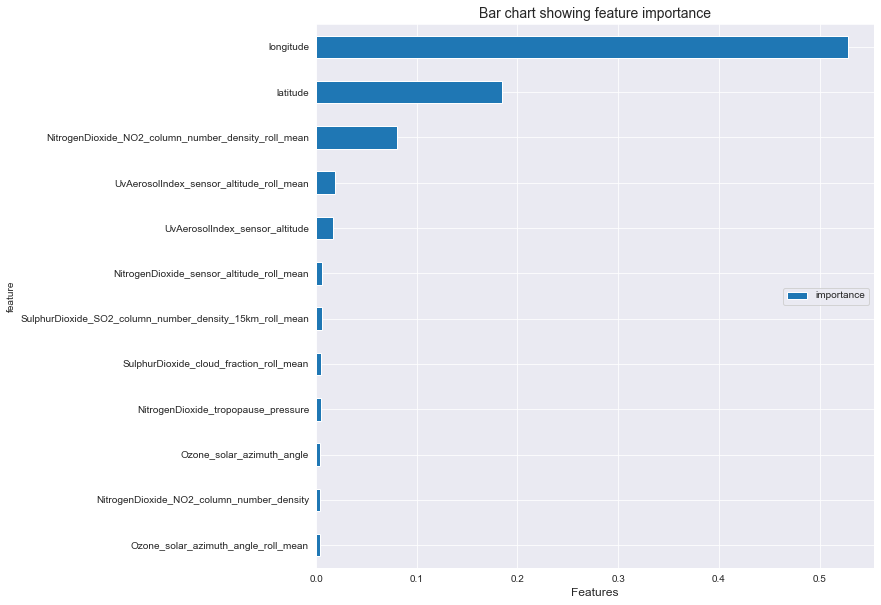

In [40]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

<a name="Predictions"></a>
## 12. Making predictions of the test set and creating a submission file

In [41]:
# Make prediction on the test set
test_df = test_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location'], axis = 1).fillna(0)
predictions = clf.predict(test_df)

# # Create a submission file
sub_file = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_eng.ID_LAT_LON_YEAR_WEEK, 'emission': predictions})
sub_file.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,2745.77148
1,ID_-23.53_27.47_2019_2,2616.14424
2,ID_-23.53_27.47_2019_3,2599.81667
3,ID_-23.53_27.47_2019_4,2798.12155
4,ID_-23.53_27.47_2019_5,5240.32166


In [33]:
# Create file
sub_file.to_csv('BaselineSubmission.csv', index = False) # Download subfile and submit to zindi for scoring

## ALL THE BEST AND HAVE FUN &#x1F60E;